<h1 align=center><font size = 5>Finding the Best Coffee Shop Locations in Boston</font></h1>

## Introduction
Boston is one of the oldest and most densely populated cities in the United States. It has a rich history, vibrant culture and is considered a world leader in higher education. It also attracts millions of tourists, young students and professionals every year. Therefore, Boston is the perfect place for entrepreneurs to start a business or open a restaurant.

This project aims to find an optimal location for a new coffee shop in Boston. Specifically, this project is targeted to stakeholders interested in opening a coffee shop or a café in Boston. Since there are already so many coffee shops in Boston, We need to locate areas that have no or few coffee shops and are densely populated. We also prefer locations that have many universities and young students as these are the main customers for a coffee shop.

Data science and machine learning techniques are used to visualize the neighborhoods in Boston and their clusters. Stakeholders can choose the best neighborhoods for their coffee shops based on the above criteria accordingly. 


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import geocoder

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1. Data pre-processing


First, let's read the csv file to get the zip code and population of each neighborhood

In [85]:
df = pd.read_csv('boston_neighborhoods.csv', dtype='str')
df.head()

,ZipCode,Neighborhood,Population
0,02108,Beacon Hill,4454
1,02116,Back Bay,23157
2,02199,Prudential,1157
3,02109,Markets / Inner Harbor,4190
4,02110,Financial District / Wharves,2314


In [86]:
# # Delete some neighborhoods that are not in Boston
# # Delete all Downtown Boston's Zip Codes because they are just building addresses.
# df.drop(df.index[(df["Neighborhood"] == "Cambridge")], axis=0, inplace=True)
# df.drop(df.index[(df["Neighborhood"] == "Somerville")], axis=0, inplace=True)
# df.drop(df.index[(df["Neighborhood"] == "Brookline Village")], axis=0, inplace=True)
# df.drop(df.index[(df["Neighborhood"] == "Brookline")], axis=0, inplace=True)
# df.drop(df.index[(df["Neighborhood"] == "Downtown Boston")], axis=0, inplace=True)
# df = df.reset_index(drop=True)
# df.head()

Make sure the dataframe has all 29 neighborhoods

In [87]:
# number of rows of the dataframe
df.shape

(29, 3)

In [88]:
# Sort the data by population in descending order
df['Population'] = df['Population'].astype(int)
df = df.sort_values(by='Population', ascending=False)
df = df.reset_index(drop=True)
df.head()

,ZipCode,Neighborhood,Population
0,02124,Dorchester / Codman Square,56649
1,02128,East Boston,47263
2,02135,Brighton,44951
3,02130,Jamaica Plain,40749
4,02127,South Boston,37634


Use the Geocoder package to get the coordinates of each neighborhood

In [89]:
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Boston, Massachusetts'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [90]:
zip_codes = df['ZipCode']    
coords = [get_latlng(zip_code) for zip_code in zip_codes.tolist()]

In [91]:
boston_data = df
boston_coords = pd.DataFrame(coords, columns = ['Latitude', 'Longitude'])
boston_data['Latitude'] = boston_coords['Latitude']
boston_data['Longitude'] = boston_coords['Longitude']
boston_data.head()

,ZipCode,Neighborhood,Population,Latitude,Longitude
0,02124,Dorchester / Codman Square,56649,42.281318,-71.078176
1,02128,East Boston,47263,42.374455,-71.035972
2,02135,Brighton,44951,42.351176,-71.167162
3,02130,Jamaica Plain,40749,42.300184,-71.130992
4,02127,South Boston,37634,42.344146,-71.060653


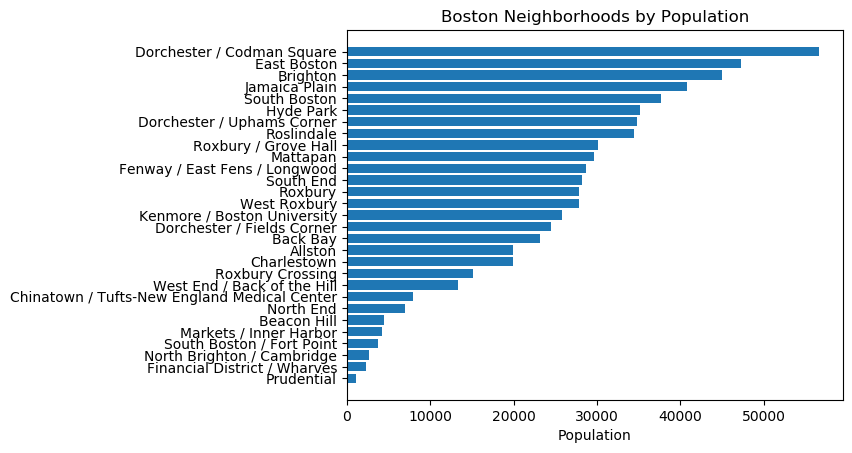

In [127]:
# Create a bar chart Neighborhood vs Population
# Reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html
import matplotlib.pyplot as plt  
plt.rcdefaults()
fig, ax = plt.subplots()

x_axis = boston_data['Neighborhood']
y_axis = boston_data['Population']
y_pos = np.arange(len(x_axis))

ax.barh(y_pos, y_axis, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(x_axis)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Population')
ax.set_title('Boston Neighborhoods by Population')

plt.show()

#### Use geopy library to get the latitude and longitude values of Boston

In [92]:
address = 'Boston, Massachusetts'

geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


#### Create a map of Boston with neighborhoods superimposed on top

In [93]:
# create map of Boston using latitude and longitude values
map_boston = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(boston_data['Latitude'], boston_data['Longitude'], boston_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them

## 2. Explore Neighborhoods in Boston using Foursquare API


Define Foursquare Credentials and Version

In [128]:
CLIENT_ID = '' # Foursquare ID
CLIENT_SECRET = '' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [101]:
# function to get all nearby venues in all the neighborhoods in Boston
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [102]:
# run the above function on each neighborhood and create a new dataframe called boston_venues
boston_venues = getNearbyVenues(names=boston_data['Neighborhood'], 
                                   latitudes=boston_data['Latitude'],
                                   longitudes=boston_data['Longitude'])

Dorchester / Codman Square
East Boston
Brighton
Jamaica Plain
South Boston
Hyde Park
Dorchester / Uphams Corner
Roslindale
Roxbury / Grove Hall
Mattapan
Fenway / East Fens / Longwood
South End
Roxbury
West Roxbury
Kenmore / Boston University
Dorchester / Fields Corner
Back Bay
Allston
Charlestown
Roxbury Crossing
West End / Back of the Hill
Chinatown / Tufts-New England Medical Center
North End
Beacon Hill
Markets / Inner Harbor
South Boston / Fort Point
North Brighton / Cambridge
Financial District / Wharves
Prudential


In [103]:
# check the size of the resulting dataframe
print(boston_venues.shape)
boston_venues.head()

(1402, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dorchester / Codman Square,42.281318,-71.078176,Norfolk Hardware & Home Center,42.278690,-71.080695,Hardware Store
1,Dorchester / Codman Square,42.281318,-71.078176,Pit Stop BBQ,42.281019,-71.084142,BBQ Joint
2,Dorchester / Codman Square,42.281318,-71.078176,Planet Fitness - Temporarily Closed,42.277919,-71.081130,Gym / Fitness Center
3,Dorchester / Codman Square,42.281318,-71.078176,Diwali,42.280037,-71.081372,Indian Restaurant
4,Dorchester / Codman Square,42.281318,-71.078176,Morton Seafood And pizza,42.280885,-71.083953,American Restaurant


In [104]:
# check how many venues were returned for each neighborhood
boston_count = boston_venues.groupby('Neighborhood').count().reset_index()
boston_count = boston_count.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1)
boston_count = boston_count.sort_values(by='Venue', ascending=False).reset_index(drop=True)
boston_count.head()

,Neighborhood,Venue
0,Beacon Hill,100
1,Prudential,100
2,Chinatown / Tufts-New England Medical Center,100
3,North End,100
4,Markets / Inner Harbor,100


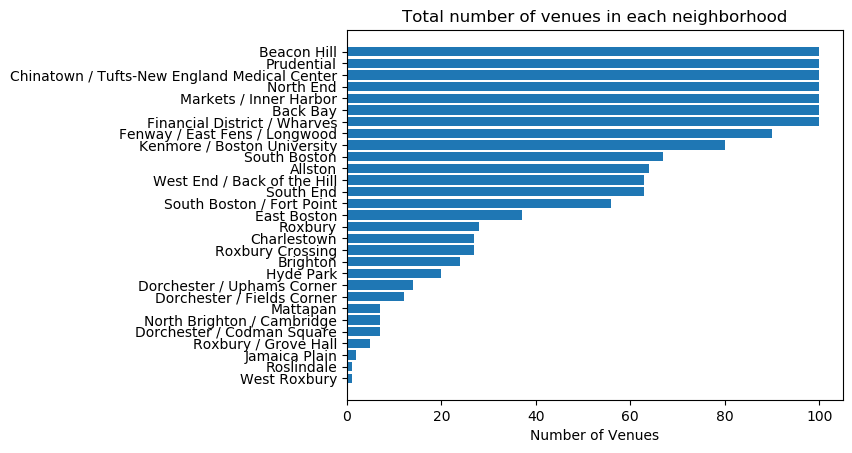

In [105]:
# Create a bar chart Neighborhood vs Number of Venues
# Reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html
import matplotlib.pyplot as plt  
plt.rcdefaults()
fig, ax = plt.subplots()

x_axis = boston_count['Neighborhood']
y_axis = boston_count['Venue']
y_pos = np.arange(len(x_axis))

ax.barh(y_pos, y_axis, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(x_axis)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Venues')
ax.set_title('Total number of venues in each neighborhood')

plt.show()

We can see that most neighborhoods in the downtown area (Beacon Hill, Back Bay, Financial District, Harborfront)  have reached the 100 limit venues, while most residential areas in the suburbs (Roxbury, Jamaica Plain, Roslindale, West Roxbury) have low number of venues. 

Let's find out how many unique categories can be curated from all the returned venues

In [106]:
print('There are {} uniques categories.'.format(len(boston_venues['Venue Category'].unique())))

There are 225 uniques categories.


## 3. Analyze Each Neighborhood

In [107]:
# one hot encoding
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_venues['Neighborhood'] 

# move neighborhood column to the first column
first_column = boston_onehot.pop('Neighborhood')
boston_onehot.insert(0, 'Neighborhood', first_column)

boston_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Cambodian Restaurant,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Hockey Rink,College Stadium,Colombian Restaurant,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Other Repair Shop,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Dorchester / Codman Square,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dorchester / Codman Square,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [108]:
# examine the new dataframe size.
boston_onehot.shape

(1402, 225)

In [109]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()
boston_grouped

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Cambodian Restaurant,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Hockey Rink,College Stadium,Colombian Restaurant,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Other Repair Shop,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Allston,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.046875,0.000000,0.000000,0.000000,0.00,0.031250,0.000000,0.000000,0.000000,0.0000,0.00,0.00,0.00,0.0000,0.00,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.015625,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.046875,0.00,0.000000,0.00,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.015625,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.00,0.015625,0.015625,0.015625,0.000000,0.015625,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.015625,0.015625,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.015625,0.000000,0.015625,0.000000,0.000000,0.015625,0.

In [110]:
# confirm the new size
boston_grouped.shape

(29, 225)

In [111]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
                venue  freq
0   Korean Restaurant  0.08
1    Asian Restaurant  0.05
2  Chinese Restaurant  0.05
3         Pizza Place  0.03
4     Thai Restaurant  0.03


----Back Bay----
                venue  freq
0  Seafood Restaurant  0.05
1                 Spa  0.05
2               Hotel  0.04
3         Coffee Shop  0.04
4      Cosmetics Shop  0.04


----Beacon Hill----
                 venue  freq
0          Coffee Shop  0.07
1        Historic Site  0.06
2  American Restaurant  0.04
3       Sandwich Place  0.04
4                Plaza  0.03


----Brighton----
                venue  freq
0  Chinese Restaurant  0.12
1         Pizza Place  0.08
2                Park  0.08
3    Sushi Restaurant  0.08
4  Italian Restaurant  0.04


----Charlestown----
                 venue  freq
0          Coffee Shop  0.11
1    Convenience Store  0.07
2          Pizza Place  0.07
3          Yoga Studio  0.04
4  Monument / Landmark  0.04


----Chinatown / Tufts-New England Medical Center

Let's put that into a pandas dataframe

In [112]:
# function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [113]:
# create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Korean Restaurant,Asian Restaurant,Chinese Restaurant,Coffee Shop,Seafood Restaurant,Rental Car Location,Pizza Place,Bakery,Thrift / Vintage Store,Liquor Store
1,Back Bay,Spa,Seafood Restaurant,Gym,Coffee Shop,Cosmetics Shop,Hotel,Boutique,American Restaurant,Gym / Fitness Center,Gourmet Shop
2,Beacon Hill,Coffee Shop,Historic Site,American Restaurant,Sandwich Place,Falafel Restaurant,Hotel,Restaurant,Plaza,Asian Restaurant,Bakery
3,Brighton,Chinese Restaurant,Pizza Place,Park,Sushi Restaurant,Trail,Latin American Restaurant,Noodle House,Bar,Wings Joint,Thai Restaurant
4,Charlestown,Coffee Shop,Pizza Place,Convenience Store,Donut Shop,Liquor Store,Monument / Landmark,Café,Shopping Mall,National Park,Yoga Studio


## 4. Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [114]:
# set number of clusters
kclusters = 5

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [115]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boston_merged = boston_data

# merge downtown_grouped with downtown_data to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

boston_merged.head()

,ZipCode,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,02124,Dorchester / Codman Square,56649,42.281318,-71.078176,0,Donut Shop,Gym / Fitness Center,American Restaurant,Indian Restaurant,Hardware Store,BBQ Joint,Liquor Store,Farmers Market,Ethiopian Restaurant,Falafel Restaurant
1,02128,East Boston,47263,42.374455,-71.035972,0,Latin American Restaurant,Pharmacy,Park,Sandwich Place,Convenience Store,Fast Food Restaurant,Department Store,Liquor Store,Fried Chicken Joint,Deli / Bodega
2,02135,Brighton,44951,42.351176,-71.167162,0,Chinese Restaurant,Pizza Place,Park,Sushi Restaurant,Trail,Latin American Restaurant,Noodle House,Bar,Wings Joint,Thai Restaurant
3,02130,Jamaica Plain,40749,42.300184,-71.130992,3,Monument / Landmark,Home Service,Yoga Studio,Dumpling Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
4,02127,South Boston,37634,42.344146,-71.060653,0,Japanese Restaurant,Coffee Shop,Italian Restaurant,Grocery Store,Hotel,Art Gallery,Asian Restaurant,Bookstore,New American Restaurant,Pharmacy


Finally, let's visualize the resulting clusters

In [116]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['Latitude'], boston_merged['Longitude'], boston_merged['Neighborhood'], boston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 0:
This cluster includes neighborhoods that already have a lot of coffee shops, cafes and restaurants. These neighborhoods are located in the downtown area (commercial zone) or residential areas with large populations. It's best to avoid these areas when opening a new coffee shop.

In [117]:
# Cluster 0:  
boston_merged.loc[boston_merged['Cluster Labels'] == 0, boston_merged.columns[[1] + [2] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dorchester / Codman Square,56649,0,Donut Shop,Gym / Fitness Center,American Restaurant,Indian Restaurant,Hardware Store,BBQ Joint,Liquor Store,Farmers Market,Ethiopian Restaurant,Falafel Restaurant
1,East Boston,47263,0,Latin American Restaurant,Pharmacy,Park,Sandwich Place,Convenience Store,Fast Food Restaurant,Department Store,Liquor Store,Fried Chicken Joint,Deli / Bodega
2,Brighton,44951,0,Chinese Restaurant,Pizza Place,Park,Sushi Restaurant,Trail,Latin American Restaurant,Noodle House,Bar,Wings Joint,Thai Restaurant
4,South Boston,37634,0,Japanese Restaurant,Coffee Shop,Italian Restaurant,Grocery Store,Hotel,Art Gallery,Asian Restaurant,Bookstore,New American Restaurant,Pharmacy
5,Hyde Park,35213,0,American Restaurant,Pizza Place,Grocery Store,Convenience Store,Train Station,Plaza,Caribbean Restaurant,Donut Shop,Sandwich Place,Bar
6,Dorchester / Uphams Corner,34847,0,Café,Coffee Shop,Pub,Deli / Bodega,Hotel,Bar,Vietnamese Restaurant,Pizza Place,Bank,Liquor Store
9,Mattapan,29620,0,Convenience Store,Sandwich Place,Baseball Field,Grocery Store,Chinese Restaurant,Pharmacy,Liquor Store,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
10,Fenway / East Fens / Longwood,28652,0,Clothing Store,Coffee Shop,Ice Cream Shop,Concert Hall,Shoe Store,Hotel Bar,Bookstore,Plaza,Theater,Sandwich Place
11,South End,28262,0,Pizza Place,Donut Shop,Latin American Restaurant,Café,Sandwich Place,Coffee Shop,Park,Tapas Restaurant,Deli / Bodega,Mediterranean Restaurant
12,Roxbury,27818,0,Donut Shop,Hotel,Convenience Store,Sandwich Place,Café,Breakfast Spot,Thrift / Vintage Store,Pharmacy,Rental Car Location,Caribbean Restaurant


#### Cluster 1:
These are residential areas in the suburbs of Boston. The most common venues are lakes, flower shops, flea and fish markets. There are not many coffee shops or cafes in these neighborhoods. The populations of these neighborhoods are quite large (ranked 7 and 13). These are good locations to open a coffee shop.

In [118]:
# Cluster 1:  
boston_merged.loc[boston_merged['Cluster Labels'] == 1, boston_merged.columns[[1] + [2] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Roslindale,34419,1,Lake,Yoga Studio,Dumpling Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant
13,West Roxbury,27801,1,Lake,Yoga Studio,Dumpling Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant


#### Cluster 2:
This is the university area with many parks, sports venues, and residential buildings. There are not many coffee shops in this neighborhood. This is a good place to open a coffee shop as there are many young students in this area. 

In [119]:
# Cluster 2:  
boston_merged.loc[boston_merged['Cluster Labels'] == 2, boston_merged.columns[[1] + [2] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,North Brighton / Cambridge,2621,2,Park,College Hockey Rink,Pool,Residential Building (Apartment / Condo),Gym,College Stadium,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant


#### Cluster 3:
This is the heavily populated (rank 3) residential area in Boston. There are not many coffee shops of cafes in this area. There are some monuments/landmarks in this area which may attract tourists. This is a very good location to open a coffee shop.

In [120]:
# Cluster 3:  
boston_merged.loc[boston_merged['Cluster Labels'] == 3, boston_merged.columns[[1] + [2] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Jamaica Plain,40749,3,Monument / Landmark,Home Service,Yoga Studio,Dumpling Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market


#### Cluster 4:
This is the residential area in the suburb of Boston. It has a relatively large population (rank 8). There are many food venues but not many coffee shops. This is also a good location to open a coffee shop.

In [121]:
# Cluster 4:  
boston_merged.loc[boston_merged['Cluster Labels'] == 4, boston_merged.columns[[1] + [2] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Roxbury / Grove Hall,30159,4,Food,Brewery,Garden,Discount Store,Ethiopian Restaurant,Food Service,Food Court,Food & Drink Shop,Flower Shop,Flea Market


The resulting clusters may not imply that these areas are actually optimal locations for a new coffee shop. Our analysis only focused on areas that are densely populated but are not crowded with coffee shops. There could be many reasons why opening a coffee shop in these areas might not be feasible even if there are few competitors, such as high rents or poor public transport accessibility. Besides, choosing a different number of k can yield different clusters and we may detect other suitable areas for a coffee shop. Therefore, additional factors need to be considered in future studies.

## Conclusion
Using Foursquare API and k-means clustering algorithm, my project successfully identified the areas in Boston that are heavily populated but are not crowded with coffee shops. Stakeholders can carefully consider these recommended neighborhoods and their advantages as a starting point to make an appropriate decision on choosing a final, optimal location to open a coffee shop in Boston. In future works, different clustering algorithms and additional factors such as residents’ average income, transport accessibility and rental price may be implemented in order to improve the correctness of this analysis.